In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load data:

In [2]:
download_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv(download_dir + 'time_series_19-covid-Confirmed.csv')
df_d = pd.read_csv(download_dir + 'time_series_19-covid-Deaths.csv')
df_r = pd.read_csv(download_dir + 'time_series_19-covid-Recovered.csv')

Reformat:

In [3]:
df = df.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_d = df_d.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df_r = df_r.groupby(['Country/Region']).sum().drop(columns=['Lat','Long']).T.rename(columns={'Iran (Islamic Republic of)': 'Iran'})
df.columns.name = ''
df_d.columns.name = ''
df_r.columns.name = ''

Reformat dates:

In [4]:
last_date = df.index[-1]
df.index = np.arange(df.shape[0])[::-1]*-1
df_d.index = np.arange(df_d.shape[0])[::-1]*-1
df_r.index = np.arange(df_r.shape[0])[::-1]*-1

Compute number of closed cases as reported deaths + reported recoveries, and the number of open cases as the reported cases - the closes cases:

In [5]:
df_c = df_d + df_r
df_o = df - df_c

Select countries to plot. Here I select only those countries with >1000 reported cases, plus the Netherlands, because that's my country:

In [6]:
ind_cases = df.iloc[-1] > 1000
country_list = list(df_c.columns[ind_cases])
country_list.append('Netherlands')
colors = sns.color_palette(n_colors=len(country_list))

Show what the data looks like:

In [7]:
df.loc[:,df.columns.isin(country_list)].tail()

,China,France,Germany,Iran,Italy,"Korea, South",Netherlands,Spain,US
-4,80823,1129,1040,6566,7375,7314,265,673,518
-3,80860,1212,1176,7161,9172,7478,321,1073,583
-2,80887,1787,1457,8042,10149,7513,382,1695,959
-1,80921,2284,1908,9000,12462,7755,503,2277,1281
0,80932,2284,2078,10075,12462,7869,503,2277,1663


Let's start with plotting the total number of cases:

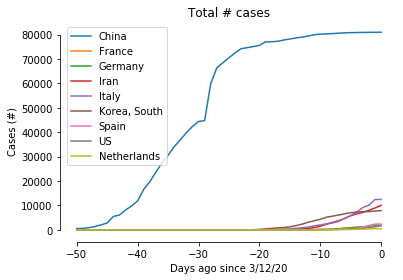

In [8]:
for country, color in zip(country_list, colors):
    plt.plot(df.loc[:,country], color=color, label=country)
plt.legend()
plt.title('Total # cases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases (#)')
sns.despine(offset=2, trim=True)

The same, but now excluding China:

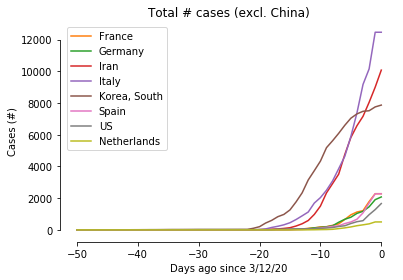

In [9]:
for country, color in zip(country_list, colors):
    if not country == 'China':
        plt.plot(df.loc[:,country], color=color, label=country)
        # plt.plot(df_c.loc[:,country].diff(), label=country)
plt.legend()
plt.title('Total # cases (excl. China)')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases (#)')
sns.despine(offset=2, trim=True)

Let's start with computing the COVID-19 mortality rate. We do this based on the data from China.  
-- Mortality rate based on the total number of cases = # deaths / # cases.  
-- Mortality rate based on the closed cases = # deaths / (# deaths + # recoveries).  
Let's compute these numbers:

In [10]:
# mortality_total = df_d.iloc[-1].sum() / df.iloc[-1].sum() * 100
# mortality_closed = df_d.iloc[-1].sum() / (df_c.iloc[-1].sum()) * 100
mortality_total = df_d['China'].iloc[-1] / df['China'].iloc[-1] * 100
mortality_closed = df_d['China'].iloc[-1] / (df_c['China'].iloc[-1]) * 100
print('mortality rate total = {}%'.format(round(mortality_total, 3)))
print('mortality rate closed = {}%'.format(round(mortality_closed, 3)))

mortality rate total = 3.919%
mortality rate closed = 4.801%


The first measure is likely to be an underestimate, because lots of open cases can still end up in death; the second measure is an overestimate, because it’s likely that deaths are closed quicker than recoveries. Thus, the true mortality rate likely lies somewhere in between. In the case of China, where the epidemic is currently under control, it's nice to see that the two measures converge (see also https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca):

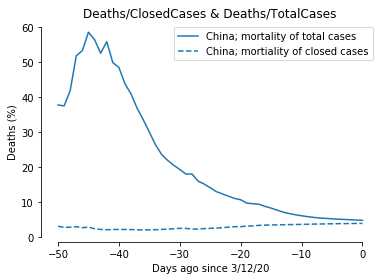

In [11]:
df_m_total = (df_d/df*100)
df_m_closed = (df_d/df_c*100)
for country, color in zip(country_list, colors):
    if (country == 'China'):
        plt.plot(df_m_closed.loc[:,country], color=color, label='{}; mortality of total cases'.format(country))
        plt.plot(df_m_total.loc[:,country], ls='--', color=color, label='{}; mortiality of closed cases'.format(country))
plt.legend()
plt.title('Deaths/ClosedCases & Deaths/TotalCases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Deaths (%)')
sns.despine(offset=2, trim=True)

Let's assume the true mortality rate lies in the middle of the two computed measures:

In [12]:
mortality = (mortality_total + mortality_closed) / 2
print(mortality)

4.360045188715001


We can use this measure to predict the number of infections based on the number of reported cases, number of deaths and the number of recoveries. Specifically: 

# *n* deaths ~ *n* × (100 / mortality rate) infections

Remember that the number of deaths is made up of the actual number of deaths, plus the predicted number of deaths based on the open cases. Thus:

In [13]:
df_d_predicted = df_d + (df_o / (100 / mortality))
df_predicted = (df_d_predicted * (100 / mortality)) 
df_predicted.tail()

,Afghanistan,Albania,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,Taiwan*,Thailand,Togo,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Vietnam
-4,4.0,0.000000,19.000000,1.0,33.935542,1.0,120.806626,104.000000,9.0,81.0,...,53.935542,40.935542,1.0,2.0,0.0,971.646384,1.0,38.0,321.806626,14.0
-3,4.0,2.000000,20.000000,1.0,33.935542,1.0,135.806626,129.000000,9.0,81.0,...,51.935542,40.935542,1.0,2.0,0.0,1058.581926,1.0,38.0,391.742168,14.0
-2,5.0,10.000000,20.000000,1.0,38.935542,1.0,151.806626,178.000000,11.0,88.0,...,51.935542,41.935542,1.0,5.0,0.0,1565.195179,1.0,62.0,496.613253,15.0
-1,7.0,33.935542,20.000000,1.0,40.935542,1.0,172.806626,242.000000,8.0,160.0,...,52.935542,46.935542,1.0,7.0,1.0,2062.679516,1.0,57.0,615.484337,22.0
0,7.0,44.935542,37.935542,0.0,40.935542,4.0,172.806626,319.935542,8.0,160.0,...,50.935542,57.935542,1.0,7.0,1.0,2528.421684,1.0,68.0,615.484337,23.0


For China we can see that our predicted is not too far of:

In [14]:
print('predicted # cases China = {}'.format(int(df_predicted['China'].iloc[-1])))
print('reported # cases China = {}'.format(df['China'].iloc[-1]))

predicted # cases China = 87610
reported # cases China = 80932


In other words, in China, **most** of all the prediced COVID19 cases are reported and tracked. Let's plot that:

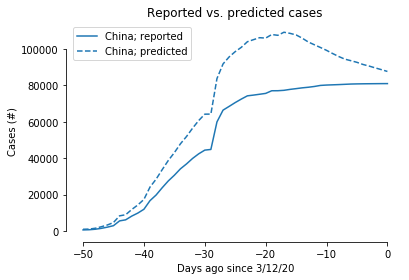

In [15]:
for country, color in zip(country_list, colors):
    if country == 'China':
        plt.plot(df.loc[:,country], color=color, label='{}; reported'.format(country))
        plt.plot(df_predicted.loc[:,country], color=color, ls='--', label='{}; predicted'.format(country))
plt.legend()
plt.title('Reported vs. predicted cases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases (#)')
# plt.ylim(0,75)
sns.despine(offset=2, trim=True)

You can see that this simple model predicted too many cases at some point. The reasons is the sudden jump in number of reported cases, due to a change in the criterion used by the Chinese government.

We can also compute how many more cases are predicted than are reported:

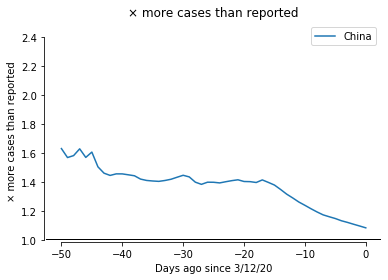

In [16]:
df_increase = df_predicted / df
for country, color in zip(country_list, colors):
    if country == 'China':
        plt.plot(df_increase.loc[:,country], color=color, label=country)
plt.legend()
plt.title('× more cases than reported')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('× more cases than reported')
plt.ylim(1,2.5)
plt.axhline(1, lw=2, color='k')
sns.despine(offset=2, trim=True)

Thus, for a long time it seems that there were 1.4 times as many cases in China as reported. Reasons for this are: (i) infected people think they just have a bad cold and don't get themselves checked, (ii) infected people do not show symptoms because of 14 days incubation time, and thus don't get themselves checked, (iii) not enough testing kits, etc. Whatever the reason, unreported cases mean untracked cases, and thus an increased risk of community spread.  

**Why did these untracked cases not cause more harm in China? Simply because they were all contained within the Wuhan region, and thus could not spread beyond!**
  
In other regions something different is going on...

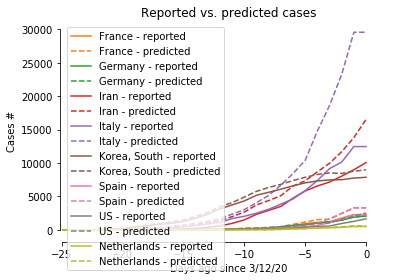

In [17]:
for country, color in zip(country_list, colors):
    if not country == 'China':
        plt.plot(df.loc[:,country], color=color, label='{} - reported'.format(country))
        plt.plot(df_predicted.loc[:,country], color=color, ls='--', label='{} - predicted'.format(country))
plt.legend(loc=2)
plt.title('Reported vs. predicted cases')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('Cases #')
plt.xlim(xmin=-25)
# plt.yscale('log')
sns.despine(offset=2, trim=True)

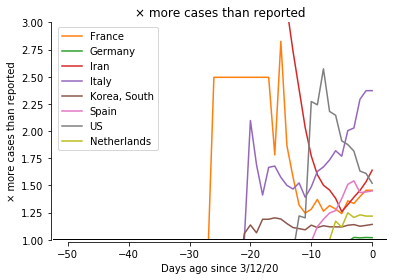

In [18]:
df_increase = df_predicted / df
for country, color in zip(country_list, colors):
    if not country == 'China':
        plt.plot(df_increase.loc[:,country], color=color, label=country)
plt.legend()
plt.title('× more cases than reported')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('× more cases than reported')
plt.ylim(1,3)
plt.axhline(1, lw=2, color='k')
sns.despine(offset=2, trim=True)

Here you see that for in the US and Italy, there are or have recently been two times as many cases as reported. This means thousands of untracked cases. In Italy there are now proper movement restrictions and social isolation practices in place, increasing the chance that the outbreak will be contained, as in China. In the US, however, the response in terms of testing and movement restrictions has been completely inadequate, meaning that thee virus can still go wherever it pleases.

Note that the above metric tends to be very high just *before* an exponential increase (compare this last figure, to the first two). Let's plot that for the US in same figure:

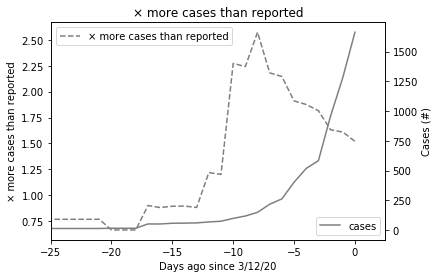

In [19]:
df_increase = df_predicted / df
for country, color in zip(country_list, colors):
    if country == 'US':
        plt.plot(df_increase.loc[:,country], color=color, ls='--', label='× more cases than reported')
plt.title('× more cases than reported')
plt.xlabel('Days ago since {}'.format(last_date))
plt.ylabel('× more cases than reported')
plt.xlim(xmin=-25)
plt.legend(loc=2)
plt.twinx()
for country, color in zip(country_list, colors):
    if country == 'US':
        plt.plot(df.loc[:,country], color=color, label='cases')
plt.ylabel('Cases (#)')
plt.legend(loc=4)

In sum, I predict that there are this many more cases in each country than reported today:

In [21]:
(df_increase[country_list].iloc[-1] * df[country_list].iloc[-1]) - df[country_list].iloc[-1]


China            6678.539553
France           1040.906021
Germany            40.806626
Iran             6451.347563
Italy           17095.693320
Korea, South     1114.745779
Spain            1023.454816
US                865.421684
Netherlands       109.677711
Name: 0, dtype: float64

*Disclaimer: predictions are based on the mortality rate as observed in China. The mortality rate will likely vary per country and region due to: (i) age distribution of the population, (ii) quality and availability of health care, (iii) climate, etc.*

Schematic of analysis performed here:

<img src="schematic.png">